In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
outlets_df = pd.read_csv("./dataset/outlets_data.csv")
sales_df = pd.read_csv("./dataset/sales_data.csv")
week_df = pd.read_csv("./dataset/week_data.csv")
product_df = pd.read_csv("./dataset/product_data.csv")

week_df["Week"] = week_df["Week"].apply(lambda x: int(x.split(" ")[1]))
week_df["Month"] = week_df["End Date"].apply(lambda x: x.split("/")[0])
sales_df = sales_df.rename(columns={"week": "Week"})

sales_level_combined_df = pd.merge(sales_df, week_df, on="Week")
sales_level_combined_df = pd.merge(sales_level_combined_df, product_df, on="pid")

sales_level_combined_df["sales_volume"] = sales_level_combined_df.apply(
    lambda x: x["no_units"] * x["volume"], axis=1
)
sales_level_combined_df["sales_revenue"] = sales_level_combined_df.apply(
    lambda x: x["no_units"] * x["price"], axis=1
)
sales_level_combined_df.head()


,Outlet_ID,Week,pid,product_name_x,no_units,Start Date,End Date,Month,volume,product_name_y,price,sales_volume,sales_revenue
0,ID7203,1,IP1,Vanilla Mini Cone,874.0,1/2/2023,1/8/2023,1,0.2,Vanilla Mini Cone,100,174.8,87400.0
1,ID1878,1,IP1,Vanilla Mini Cone,918.0,1/2/2023,1/8/2023,1,0.2,Vanilla Mini Cone,100,183.6,91800.0
2,ID1740,1,IP1,Vanilla Mini Cone,188.0,1/2/2023,1/8/2023,1,0.2,Vanilla Mini Cone,100,37.6,18800.0
3,ID4366,1,IP1,Vanilla Mini Cone,117.0,1/2/2023,1/8/2023,1,0.2,Vanilla Mini Cone,100,23.4,11700.0
4,ID4722,1,IP1,Vanilla Mini Cone,327.0,1/2/2023,1/8/2023,1,0.2,Vanilla Mini Cone,100,65.4,32700.0


In [18]:
outlet_stats_df = outlets_df.copy()

# total revenue
revenue_totals = (
    sales_level_combined_df.groupby("Outlet_ID")["sales_revenue"]
    .sum()
    .reset_index(name="revenue_totals")
)
outlet_stats_df = pd.merge(outlet_stats_df, revenue_totals, on="Outlet_ID")

# total volume
volume_totals = (
    sales_level_combined_df.groupby("Outlet_ID")["sales_volume"]
    .sum()
    .reset_index(name="volume_totals")
)
outlet_stats_df = pd.merge(outlet_stats_df, volume_totals, on="Outlet_ID")

# total units
units_totals = (
    sales_level_combined_df.groupby("Outlet_ID")["no_units"]
    .sum()
    .reset_index(name="units_totals")
)
outlet_stats_df = pd.merge(outlet_stats_df, units_totals, on="Outlet_ID")

# revenue by product
for pid in product_df["pid"].unique():
    pid_df = sales_level_combined_df[sales_level_combined_df["pid"] == pid]
    pid_df = (
        pid_df.groupby("Outlet_ID")["sales_revenue"]
        .sum()
        .reset_index(name="revenue_" + str(pid))
    )
    outlet_stats_df = pd.merge(outlet_stats_df, pid_df, on="Outlet_ID")

# volume by product
for pid in product_df["pid"].unique():
    pid_df = sales_level_combined_df[sales_level_combined_df["pid"] == pid]
    pid_df = (
        pid_df.groupby("Outlet_ID")["sales_volume"]
        .sum()
        .reset_index(name="volume_" + str(pid))
    )
    outlet_stats_df = pd.merge(outlet_stats_df, pid_df, on="Outlet_ID")

# units by product
for pid in product_df["pid"].unique():
    pid_df = sales_level_combined_df[sales_level_combined_df["pid"] == pid]
    pid_df = (
        pid_df.groupby("Outlet_ID")["no_units"]
        .sum()
        .reset_index(name="units_" + str(pid))
    )
    outlet_stats_df = pd.merge(outlet_stats_df, pid_df, on="Outlet_ID")

# revenue by month
for month in week_df["Month"].unique():
    month_df = sales_level_combined_df[sales_level_combined_df["Month"] == month]
    month_df = (
        month_df.groupby("Outlet_ID")["sales_revenue"]
        .sum()
        .reset_index(name="revenue_month" + str(month))
    )
    outlet_stats_df = pd.merge(outlet_stats_df, month_df, on="Outlet_ID")

# volume by month
for month in week_df["Month"].unique():
    month_df = sales_level_combined_df[sales_level_combined_df["Month"] == month]
    month_df = (
        month_df.groupby("Outlet_ID")["sales_volume"]
        .sum()
        .reset_index(name="volume_month" + str(month))
    )
    outlet_stats_df = pd.merge(outlet_stats_df, month_df, on="Outlet_ID")

# volume in week 7
week7_df = sales_level_combined_df[sales_level_combined_df["Week"] == 7]
week7_df = (
    week7_df.groupby("Outlet_ID")["sales_volume"]
    .sum()
    .reset_index(name="volume_week7")
)
outlet_stats_df = pd.merge(outlet_stats_df, week7_df, on="Outlet_ID")

# median weekly sales volume per outlet
# TODO

print(outlet_stats_df.columns)
outlet_stats_df.head()


Index(['Outlet_ID', 'area(sqft)', 'revenue_totals', 'volume_totals',
       'units_totals', 'revenue_IP1', 'revenue_IP2', 'revenue_IP3',
       'revenue_IP4', 'revenue_IP5', 'revenue_BP1', 'revenue_BP2',
       'revenue_BP3', 'revenue_BP4', 'revenue_BP5', 'volume_IP1', 'volume_IP2',
       'volume_IP3', 'volume_IP4', 'volume_IP5', 'volume_BP1', 'volume_BP2',
       'volume_BP3', 'volume_BP4', 'volume_BP5', 'units_IP1', 'units_IP2',
       'units_IP3', 'units_IP4', 'units_IP5', 'units_BP1', 'units_BP2',
       'units_BP3', 'units_BP4', 'units_BP5', 'revenue_month1',
       'revenue_month2', 'revenue_month3', 'volume_month1', 'volume_month2',
       'volume_month3', 'volume_week7'],
      dtype='object')


,Outlet_ID,area(sqft),revenue_totals,volume_totals,units_totals,revenue_IP1,revenue_IP2,revenue_IP3,revenue_IP4,revenue_IP5,...,units_BP3,units_BP4,units_BP5,revenue_month1,revenue_month2,revenue_month3,volume_month1,volume_month2,volume_month3,volume_week7
0,ID8631,4024,7413370.0,10495.4,38213.0,699800.0,500580.0,577940.0,765900.0,917400.0,...,667.0,801.0,658.0,2345670.0,2747920.0,2319780.0,3392.2,3944.6,3158.6,1033.2
1,ID8631,3196,7413370.0,10495.4,38213.0,699800.0,500580.0,577940.0,765900.0,917400.0,...,667.0,801.0,658.0,2345670.0,2747920.0,2319780.0,3392.2,3944.6,3158.6,1033.2
2,ID3946,5044,18810070.0,26056.6,92431.0,1574000.0,1372680.0,1845140.0,1694500.0,1825700.0,...,1885.0,1751.0,2520.0,6400050.0,5390640.0,7019380.0,9120.4,7658.2,9278.0,2139.0
3,ID3946,4687,18810070.0,26056.6,92431.0,1574000.0,1372680.0,1845140.0,1694500.0,1825700.0,...,1885.0,1751.0,2520.0,6400050.0,5390640.0,7019380.0,9120.4,7658.2,9278.0,2139.0
4,ID2819,4803,10527440.0,16864.8,70644.0,1446500.0,1326960.0,1627230.0,1207000.0,1115200.0,...,793.0,647.0,680.0,3471970.0,3578240.0,3477230.0,5520.6,5701.4,5642.8,1516.2


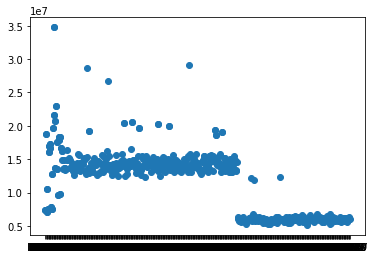

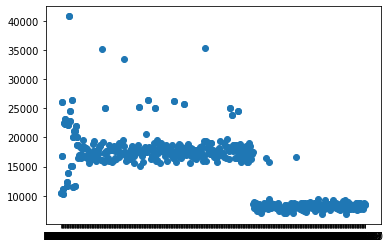

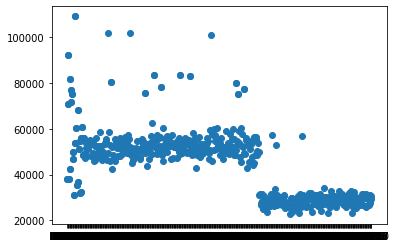

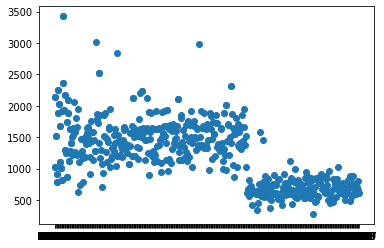

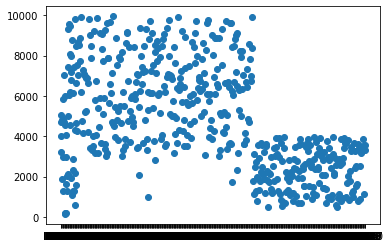

In [27]:
# revenue by outlet
plt.scatter(outlet_stats_df["Outlet_ID"], outlet_stats_df["revenue_totals"])
plt.title("Revenue by Outlet")
plt.show()

# volume by outlet
plt.scatter(outlet_stats_df["Outlet_ID"], outlet_stats_df["volume_totals"])
plt.title("Volume by Outlet")
plt.show()

# units by outlet
plt.scatter(outlet_stats_df["Outlet_ID"], outlet_stats_df["units_totals"])
plt.title("Units by Outlet")
plt.show()

# volume week 7 by outlet
plt.scatter(outlet_stats_df["Outlet_ID"], outlet_stats_df["volume_week7"])
plt.title("Volume Week 7 by Outlet")
plt.show()

# area by outlet
plt.scatter(outlet_stats_df["Outlet_ID"], outlet_stats_df["area(sqft)"])
plt.title("Area by Outlet")
plt.show()

In [31]:
# Autoencoder

import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=input_size, out_features=hidden_size
        )
        self.encoder_output_layer = nn.Linear(
            in_features=hidden_size, out_features=output_size
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=output_size, out_features=hidden_size
        )
        self.decoder_output_layer = nn.Linear(
            in_features=hidden_size, out_features=input_size
        )

        self.relu = nn.ReLU()

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = self.relu(activation)
        code = self.encoder_output_layer(activation)
        code = self.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = self.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = self.relu(activation)
        return reconstructed
    
    def encode(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = self.relu(activation)
        code = self.encoder_output_layer(activation)
        code = self.relu(code)
        return code

/home/sandil/Work/envBase/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

input_df = outlet_stats_df.copy()
for col in input_df.columns:
    if col != "Outlet_ID":
        # input_df[col] = StandardScaler().fit_transform(input_df[col].values.reshape(-1, 1))
        input_df[col] = MinMaxScaler().fit_transform(input_df[col].values.reshape(-1, 1))

train_df, validation_df = train_test_split(input_df, test_size=0.2, random_state=1)
train_df = train_df.drop(columns=["Outlet_ID"])
validation_df = validation_df.drop(columns=["Outlet_ID"])

print(train_df.shape)
train_df.head()

(418, 41)


,area(sqft),revenue_totals,volume_totals,units_totals,revenue_IP1,revenue_IP2,revenue_IP3,revenue_IP4,revenue_IP5,revenue_BP1,...,units_BP3,units_BP4,units_BP5,revenue_month1,revenue_month2,revenue_month3,volume_month1,volume_month2,volume_month3,volume_week7
204,0.800408,0.285583,0.306887,0.355819,0.468502,0.451786,0.341848,0.405730,0.350945,0.314744,...,0.268088,0.315662,0.294979,0.354040,0.261800,0.280886,0.400831,0.272288,0.315447,0.408386
385,0.383478,0.018988,0.025130,0.041704,0.157042,0.175510,0.115744,0.128951,0.153869,0.067482,...,0.045815,0.063181,0.024059,0.069379,0.031409,0.008994,0.089792,0.053955,0.021896,0.148158
249,0.978378,0.266935,0.279632,0.303675,0.480282,0.301397,0.298150,0.334916,0.353322,0.269672,...,0.246541,0.485839,0.124686,0.323245,0.267922,0.249457,0.361114,0.283112,0.262509,0.447713
92,0.909026,0.257171,0.272094,0.309127,0.479706,0.334460,0.173644,0.418296,0.413408,0.286224,...,0.292810,0.215444,0.225941,0.292711,0.226207,0.294571,0.312178,0.261678,0.312105,0.316773
426,0.254156,0.034993,0.055938,0.105029,0.289309,0.251549,0.145009,0.162180,0.214014,0.058060,...,0.044455,0.057855,0.043515,0.048146,0.046986,0.061919,0.078575,0.077787,0.099421,0.150318


 model 43 done with val loss 0.0112.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

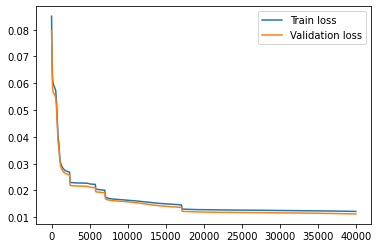

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# hidden_size = 24
# output_size = 7
criterion = nn.MSELoss()
epochs = 40000

best_model, least_val_loss, least_train_loss = None, float("inf"), float("inf")
best_train_losses, best_val_losses = [], []

counter = 1
for hidden_size in [7, 11, 15, 18, 23, 24]:
    for output_size in [5, 6, 7, 8, 9, 10, 11]:
        counter += 1

        model = Autoencoder(
            input_size=train_df.shape[1],
            hidden_size=hidden_size,
            output_size=output_size,
        ).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

        # print(model)
        train_losses = []
        validation_losses = []

        train_inputs = torch.from_numpy(train_df.values).float().to(device)
        val_inputs = torch.from_numpy(validation_df.values).float().to(device)
        for epoch in range(epochs):

            # train
            optimizer.zero_grad()
            outputs = model(train_inputs)
            loss = criterion(outputs, train_inputs)
            loss.backward()
            optimizer.step()
            # train_loss = loss.item() / len(train_df)
            train_loss = loss.item()
            train_losses.append(train_loss)

            # validation
            with torch.no_grad():
                outputs = model(val_inputs)
                loss = criterion(outputs, val_inputs)
                # validation_loss = loss.item() / len(validation_df)
                validation_loss = loss.item()
                validation_losses.append(validation_loss)

            if epoch % (epochs // 40) == 0:
                print(".", end="")

        # print("\nTrain loss: {:.4f}".format(train_loss))
        # print("Validation loss: {:.4f}".format(validation_loss))

        # plt.plot(train_losses, label="Train loss")
        # plt.plot(validation_losses, label="Validation loss")
        # plt.legend()
        # plt.show()

        if validation_loss < least_val_loss:
            least_val_loss = validation_loss
            least_train_loss = train_loss
            best_model = model
            best_train_losses = train_losses
            best_val_losses = validation_losses

        print(
            "\r model {} done with val loss {:.4f} train loss {:.4f}".format(
                counter, validation_loss, train_loss
            )
        )

print("\n", best_model)
print("Train loss: {:.4f}".format(least_train_loss))
print("Validation loss: {:.4f}".format(least_val_loss))

plt.plot(best_train_losses, label="Train loss")
plt.plot(best_val_losses, label="Validation loss")
plt.legend()
plt.show()


In [53]:
torch.save(best_model, "autoencoder1.pt")

loaded_model = torch.load("autoencoder1.pt")
print(loaded_model)
print(loaded_model(val_inputs[0].reshape(1, -1)))

Autoencoder(
  (encoder_hidden_layer): Linear(in_features=41, out_features=24, bias=True)
  (encoder_output_layer): Linear(in_features=24, out_features=11, bias=True)
  (decoder_hidden_layer): Linear(in_features=11, out_features=24, bias=True)
  (decoder_output_layer): Linear(in_features=24, out_features=41, bias=True)
  (relu): ReLU()
)
tensor([[0.8621, 0.0000, 0.3291, 0.3581, 0.4088, 0.3822, 0.3482, 0.3597, 0.0000,
         0.3923, 0.3335, 0.3638, 0.3579, 0.3240, 0.4100, 0.3759, 0.3489, 0.3514,
         0.4205, 0.3892, 0.3497, 0.3715, 0.3509, 0.3152, 0.4210, 0.3787, 0.3383,
         0.3544, 0.0000, 0.4026, 0.3408, 0.3662, 0.3613, 0.3103, 0.3693, 0.3176,
         0.3497, 0.3801, 0.3400, 0.3472, 0.3923]], device='cuda:0',
       grad_fn=<ReluBackward0>)


In [54]:
for i in range(5):
    with torch.no_grad():
        outputs = best_model(val_inputs[i].reshape(1, -1))

    print(val_inputs[i])
    print(outputs, "\n")

tensor([0.8411, 0.3324, 0.3355, 0.3523, 0.4123, 0.4090, 0.3284, 0.3755, 0.3998,
        0.4892, 0.2595, 0.4484, 0.2755, 0.2722, 0.4123, 0.4090, 0.3284, 0.3755,
        0.3998, 0.4892, 0.2595, 0.4484, 0.2755, 0.2722, 0.4123, 0.4090, 0.3284,
        0.3755, 0.3998, 0.4892, 0.2595, 0.4484, 0.2755, 0.2722, 0.3443, 0.2830,
        0.4087, 0.3702, 0.2999, 0.4017, 0.4353], device='cuda:0')
tensor([[0.8621, 0.0000, 0.3291, 0.3581, 0.4088, 0.3822, 0.3482, 0.3597, 0.0000,
         0.3923, 0.3335, 0.3638, 0.3579, 0.3240, 0.4100, 0.3759, 0.3489, 0.3514,
         0.4205, 0.3892, 0.3497, 0.3715, 0.3509, 0.3152, 0.4210, 0.3787, 0.3383,
         0.3544, 0.0000, 0.4026, 0.3408, 0.3662, 0.3613, 0.3103, 0.3693, 0.3176,
         0.3497, 0.3801, 0.3400, 0.3472, 0.3923]], device='cuda:0') 

tensor([0.0558, 0.0369, 0.0523, 0.0909, 0.1234, 0.2325, 0.2168, 0.1629, 0.2317,
        0.0616, 0.0224, 0.0660, 0.0407, 0.0686, 0.1234, 0.2325, 0.2168, 0.1629,
        0.2317, 0.0616, 0.0224, 0.0660, 0.0407, 0.0686, 0.12

In [56]:
for i in range(5):
    with torch.no_grad():
        encoded = best_model.encode(val_inputs[i].reshape(1, -1))

    print(encoded)

tensor([[1.7422, 0.5459, 0.5720, 0.7386, 0.5379, 0.7303, 0.0497, 0.2887, 0.1562,
         0.8833, 0.0000]], device='cuda:0')
tensor([[0.4354, 0.2786, 0.2677, 0.3176, 0.0563, 0.2059, 0.0485, 0.1503, 0.2181,
         0.0936, 0.0000]], device='cuda:0')
tensor([[0.1642, 0.0303, 0.1479, 0.1582, 0.1110, 0.0594, 0.0032, 0.0009, 0.2586,
         0.1104, 0.0000]], device='cuda:0')
tensor([[1.5471, 0.7731, 0.4958, 0.6156, 0.2921, 0.7593, 0.0000, 0.3029, 0.1877,
         0.9111, 0.0000]], device='cuda:0')
tensor([[0.4051, 0.2819, 0.3360, 0.2431, 0.3050, 0.3716, 0.0615, 0.1318, 0.1963,
         0.1952, 0.0000]], device='cuda:0')


In [57]:
all_inputs = torch.from_numpy(input_df.drop(columns=["Outlet_ID"]).values).float().to(device)
with torch.no_grad():
    encoded = best_model.encode(all_inputs)

# write to csv
encoded_df = pd.DataFrame(encoded.cpu().numpy())
encoded_df["Outlet_ID"] = input_df["Outlet_ID"]
encoded_df = encoded_df[["Outlet_ID"] + list(range(encoded_df.shape[1] - 1))]
encoded_df.to_csv("encoded_outlets.csv", index=False)